# Main Figure

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using LaTeXStrings
using TrajectoryIndexingUtils
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories
using JLD2, FileIO

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243


In [2]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3

# variational
∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)

25

In [3]:
# Directories where data is saved
var_dir = "artifacts/var_gap_data_export"
tog_dir = "artifacts/tog_gap_data_export"

# Load the first seed file to get metadata
var_first = load(joinpath(var_dir, "var_probs_seed_idx_1.jld2"))
tog_first = load(joinpath(tog_dir, "htog_probs_seed_idx_1.jld2"))

# Extract common parameters
Qs = var_first["Qs"]

n_seeds = length(readdir(var_dir)) - 1  # Subtract 1 for plot.png

# Initialize arrays to store loaded data
var_probs = Matrix{Any}(undef, n_seeds, length(Qs))
tog_probs = Matrix{Any}(undef, n_seeds, length(Qs))

# Load all var_probs data
for i in 1:n_seeds
    data = load(joinpath(var_dir, "var_probs_seed_idx_$(i).jld2"))
    var_probs[i, :] = data["var_probs"]
end

# Load all htog_probs data
for i in 1:n_seeds
    data = load(joinpath(tog_dir, "htog_probs_seed_idx_$(i).jld2"))
    tog_probs[i, :] = data["htog_probs"]
end

println("Loaded data for $(n_seeds) seeds across $(length(Qs)) Q values")

Loaded data for 25 seeds across 25 Q values


In [4]:
function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}},
    t_cut::Int=traj.T,
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    # Get dimension from first operator
    d = size(iso_vec_to_operator(Ũ⃗[:, 1]), 1)
    
    # Sum the objective over all timesteps from 1 to t_cut
    total = 0.0
    for t in 1:t_cut
        U_t = iso_vec_to_operator(Ũ⃗[:, t])
        ∂U_t = iso_vec_to_operator(∂Ũ⃗[1][:, t])
        # Compute ||U†∂U||² = tr((U†∂U)†(U†∂U))
        term = (U_t' * ∂U_t)' * (U_t' * ∂U_t)
        total += abs(tr(term))
    end
    
    # Normalize by the total time and dimension
    return total / (t_cut * Δt)^2 / d
end

var_obj (generic function with 2 methods)

In [5]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int=traj.T-1,
)
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    rollout = unitary_rollout(traj, sys)
    
    # Slice the rollout up to t_cut
    rollout_slice = rollout[:, 1:t_cut]
    U = iso_vec_to_operator.(eachcol(rollout_slice))
    
    # Toggle integral - sum over timesteps 1 to t_cut
    H_ti = sum(Δt[i] * U[i]' * H_error * U[i] for i in 1:t_cut)

    d = size(U[1], 1)
    
    # Total accumulated time up to t_cut
    T_total = sum(Δt[1:t_cut])
    
    # Compute the metric
    metric = abs(tr(H_ti' * H_ti)) / T_total^2 / d
    return metric
end

tog_obj (generic function with 2 methods)

In [6]:
"""
    upsample_constant(vals, dts; factor=2)

Take control values `vals` with time steps `dts` (same length),
and upsample by `factor`, returning (vals_up, dts_up).
"""
function upsample_constant_controls(vals::AbstractArray; factor::Int=1)
    vals_up = repeat(vals, inner=factor)
    return vals_up
end

function upsample_matrix(controls::AbstractArray, dts::AbstractArray; factor::Int=1)
    new_controls = []
    for c in eachrow(controls)
        new_c = upsample_constant_controls(c; factor=factor)
        T = length(c)
        push!(new_controls, new_c)
    end
    dts_up = dts[1] / factor .* ones(length(dts) * factor*T)
    new_controls = reduce(vcat, [v' for v in new_controls])
    return new_controls, dts_up
end

function tog_obj_upsample(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int=traj.T;
    factor::Int=1,
)
    T_upsampled = t_cut * factor
    controls_slice = traj.a[:, 1:t_cut]
    dts_slice = traj.Δt[1:t_cut]
    a_new, Δt_new = upsample_matrix(controls_slice, dts_slice; factor=factor)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(a_new, Δt_new, sys)))
    
    # Toggle integral - sum over all upsampled timesteps
    H_ti = sum(Δt_new[i] * U[i]' * H_error * U[i] for i in 1:T_upsampled)

    d₁ = size(U[1], 1)
    Δt₁ = Δt_new[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

tog_obj_upsample (generic function with 2 methods)

In [7]:
function tog_deriv(
    traj::NamedTrajectory,
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int
)
    Δt = get_timesteps(traj)
    
    sys = QuantumSystem(H_drives)
    U_traj = unitary_rollout(traj, sys)
    
    # Slice the rollout up to t_cut
    U_traj_slice = U_traj[:, 1:t_cut]
    U = iso_vec_to_operator.(eachcol(U_traj_slice))
    
    # Compute A(t) = U(t)† * H_error * U(t) at timestep t_cut
    A_t = U[end]' * H_error * U[end]
    
    # Toggle integral
    B_t = sum(Δt[i] * U[i]' * H_error * U[i] for i in 1:t_cut)

    d = size(U[1], 1)
    
    result = 2 * tr(A_t * B_t) / d
    
    return result
end

tog_deriv (generic function with 1 method)

In [8]:
function tog_deriv_up(
    traj::NamedTrajectory,
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64},
    t_cut::Int;
    factor::Int=1
)
    T = t_cut * factor
    controls = traj.a
    a_new, Δt_new = upsample_matrix(traj.a, traj.Δt; factor=factor)
    
    sys = QuantumSystem(H_drives)
    U_traj = unitary_rollout(a_new, Δt_new, sys)
    
    # Slice the rollout up to t_cut
    U_traj_slice = U_traj[:, 1:T]
    U = iso_vec_to_operator.(eachcol(U_traj_slice))
    
    # Compute A(t) = U(t)† * H_error * U(t) at timestep t_cut
    A_t = U[end]' * H_error * U[end]
    
    # Toggle integral
    B_t = sum(Δt_new[i] * U[i]' * H_error * U[i] for i in 1:T)

    d = size(U[1], 1)
    
    result = 2 * tr(A_t * B_t) / d
    
    return result
end

tog_deriv_up (generic function with 1 method)

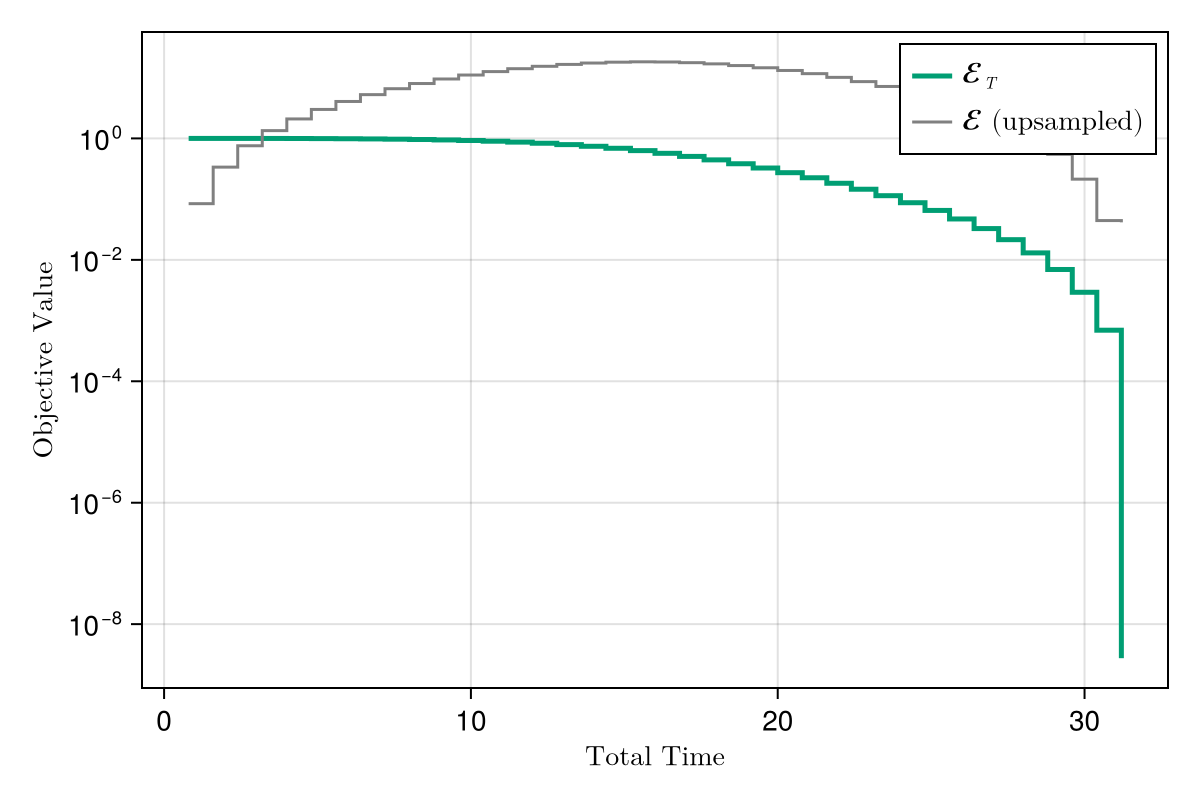

In [9]:
colors = Makie.wong_colors()


# Labels
script_tog = latexstring("\\mathcal{E}_{T}")
script_tog_up = latexstring("\\mathcal{E} \\text{ (upsampled)}")
script_diff = latexstring("\\text{Error}")

# Get trajectory info
tog_prob = tog_probs[end, end]
factor_up = 2^7
T = tog_prob.trajectory.T-1
T_upsampled = T * factor_up
Δt = tog_prob.trajectory.Δt[1]

# Compute objectives - coarse
objs_tog = [tog_obj(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t) for t in 1:T]

objs_tog_up = [tog_obj_upsample(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factor_up) for t in 1:T] ./ factor_up

# Time axes
ts = (1:T) .* Δt

# Create figure
fig = Figure(size = (600, 400))
ax_main = Axis(fig[1, 1],
    xlabel = LaTeXString("Total Time"), 
    ylabel = LaTeXString("Objective Value"),
    yscale=log10,
)
# xlims!(ax_main, 30, 32)

# Plot coarse trajectory
stairs!(ax_main, ts, objs_tog, 
    step = :post,
    label = script_tog,
    linewidth = 2.5,
    color = colors[3]
)

# Plot upsampled trajectory
stairs!(ax_main, ts, objs_tog_up, 
    step = :post,
    label = script_tog_up,
    linewidth = 1.5,
    color = :gray
)


axislegend(ax_main, position = :rt)

fig

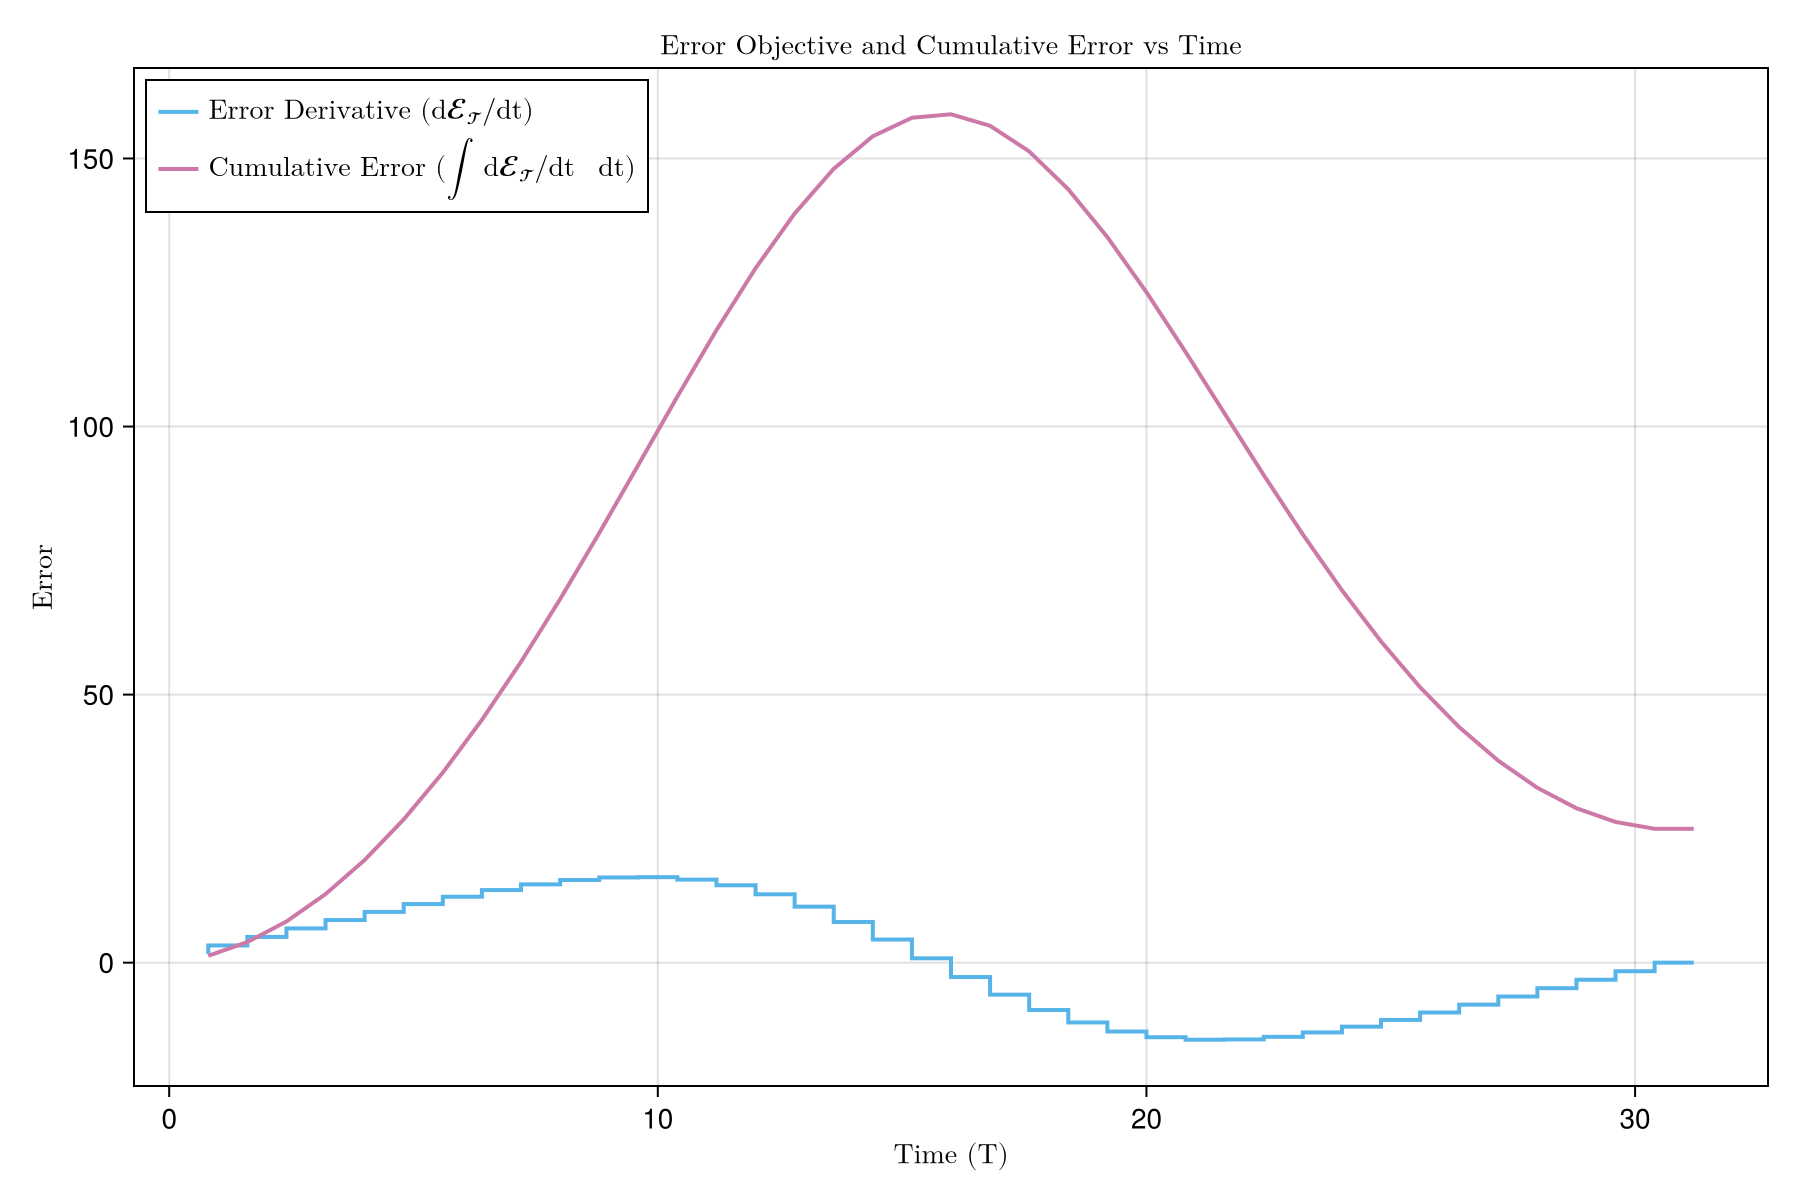

In [10]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

# Compute error derivative at each timestep
error_derivatives = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=1)) for t in 1:T]

# Compute cumulative error (integral of derivative)
cumulative_error = cumsum(error_derivatives .* Δt)
ts = (1:T) .* Δt

fig = Figure(size = (900, 600))

ax = Axis(fig[1, 1],
    title = LaTeXString("Error Objective and Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("Error"),
)

# Plot the derivative (instantaneous error)
stairs!(ax, ts, error_derivatives,
    step = :pre,
    label = LaTeXString("Error Derivative (d\\mathcal{E_T}/dt)"),
    linewidth = 2,
    color = colors[5]
)

# Plot the cumulative error (integral)
lines!(ax, ts, cumulative_error,
    label = LaTeXString("Cumulative Error (\\int d\\mathcal{E_T}/dt \\, dt)"),
    linewidth = 2,
    color = colors[4]
)

# Add legend
axislegend(ax, position = :lt)

# Display the figure
fig

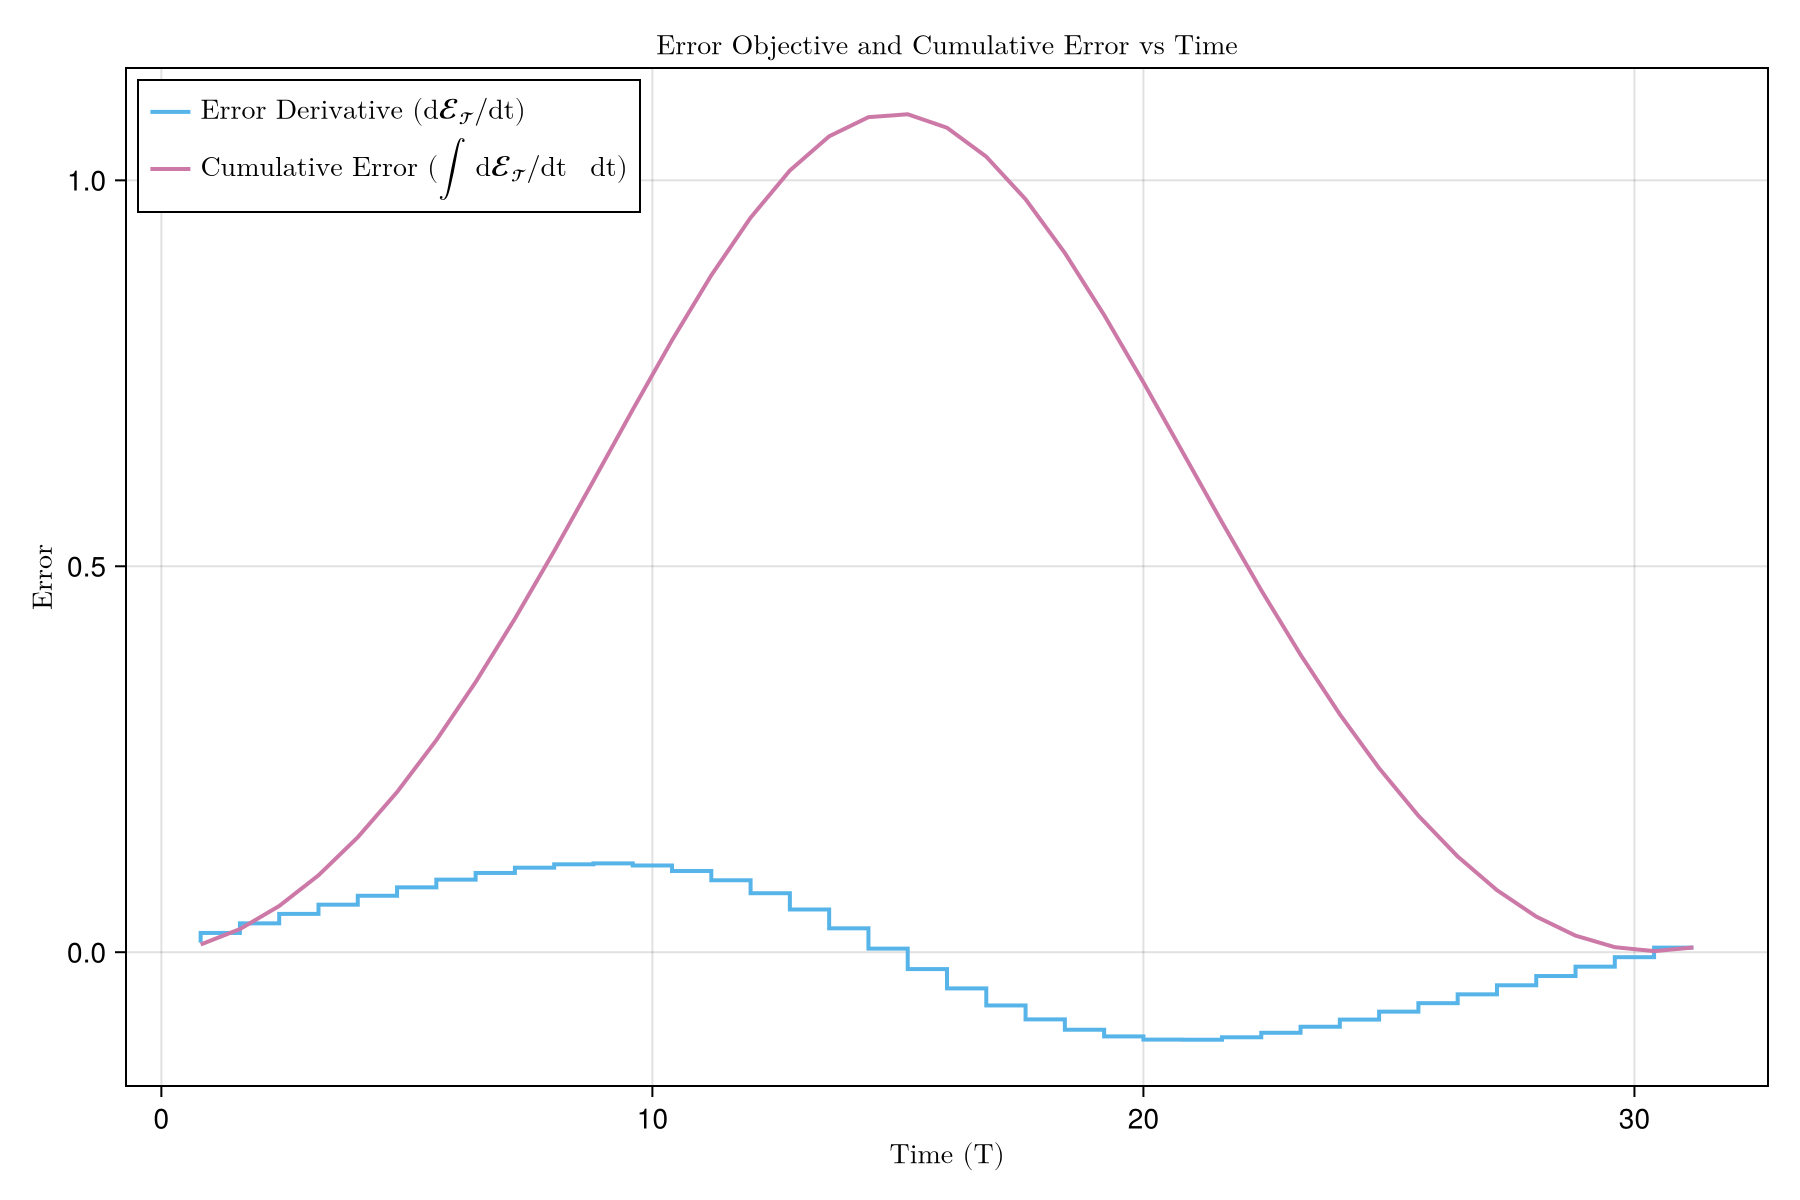

In [11]:
colors = Makie.wong_colors()
factor_up = 2^7
var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

# Compute error derivative at each timestep
error_derivatives_up = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t;factor=factor_up)) for t in 1:T] ./ factor_up

# Compute cumulative error (integral of derivative)
cumulative_error_up = cumsum(error_derivatives_up .* Δt)
ts = (1:T) .* Δt

fig = Figure(size = (900, 600))

ax = Axis(fig[1, 1],
    title = LaTeXString("Error Objective and Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("Error"),
)

# Plot the derivative (instantaneous error)
stairs!(ax, ts, error_derivatives_up,
    step = :pre,
    label = LaTeXString("Error Derivative (d\\mathcal{E_T}/dt)"),
    linewidth = 2,
    color = colors[5]
)

# Plot the cumulative error (integral)
lines!(ax, ts, cumulative_error_up,
    label = LaTeXString("Cumulative Error (\\int d\\mathcal{E_T}/dt \\, dt)"),
    linewidth = 2,
    color = colors[4]
)

# Add legend
axislegend(ax, position = :lt)

# Display the figure
fig

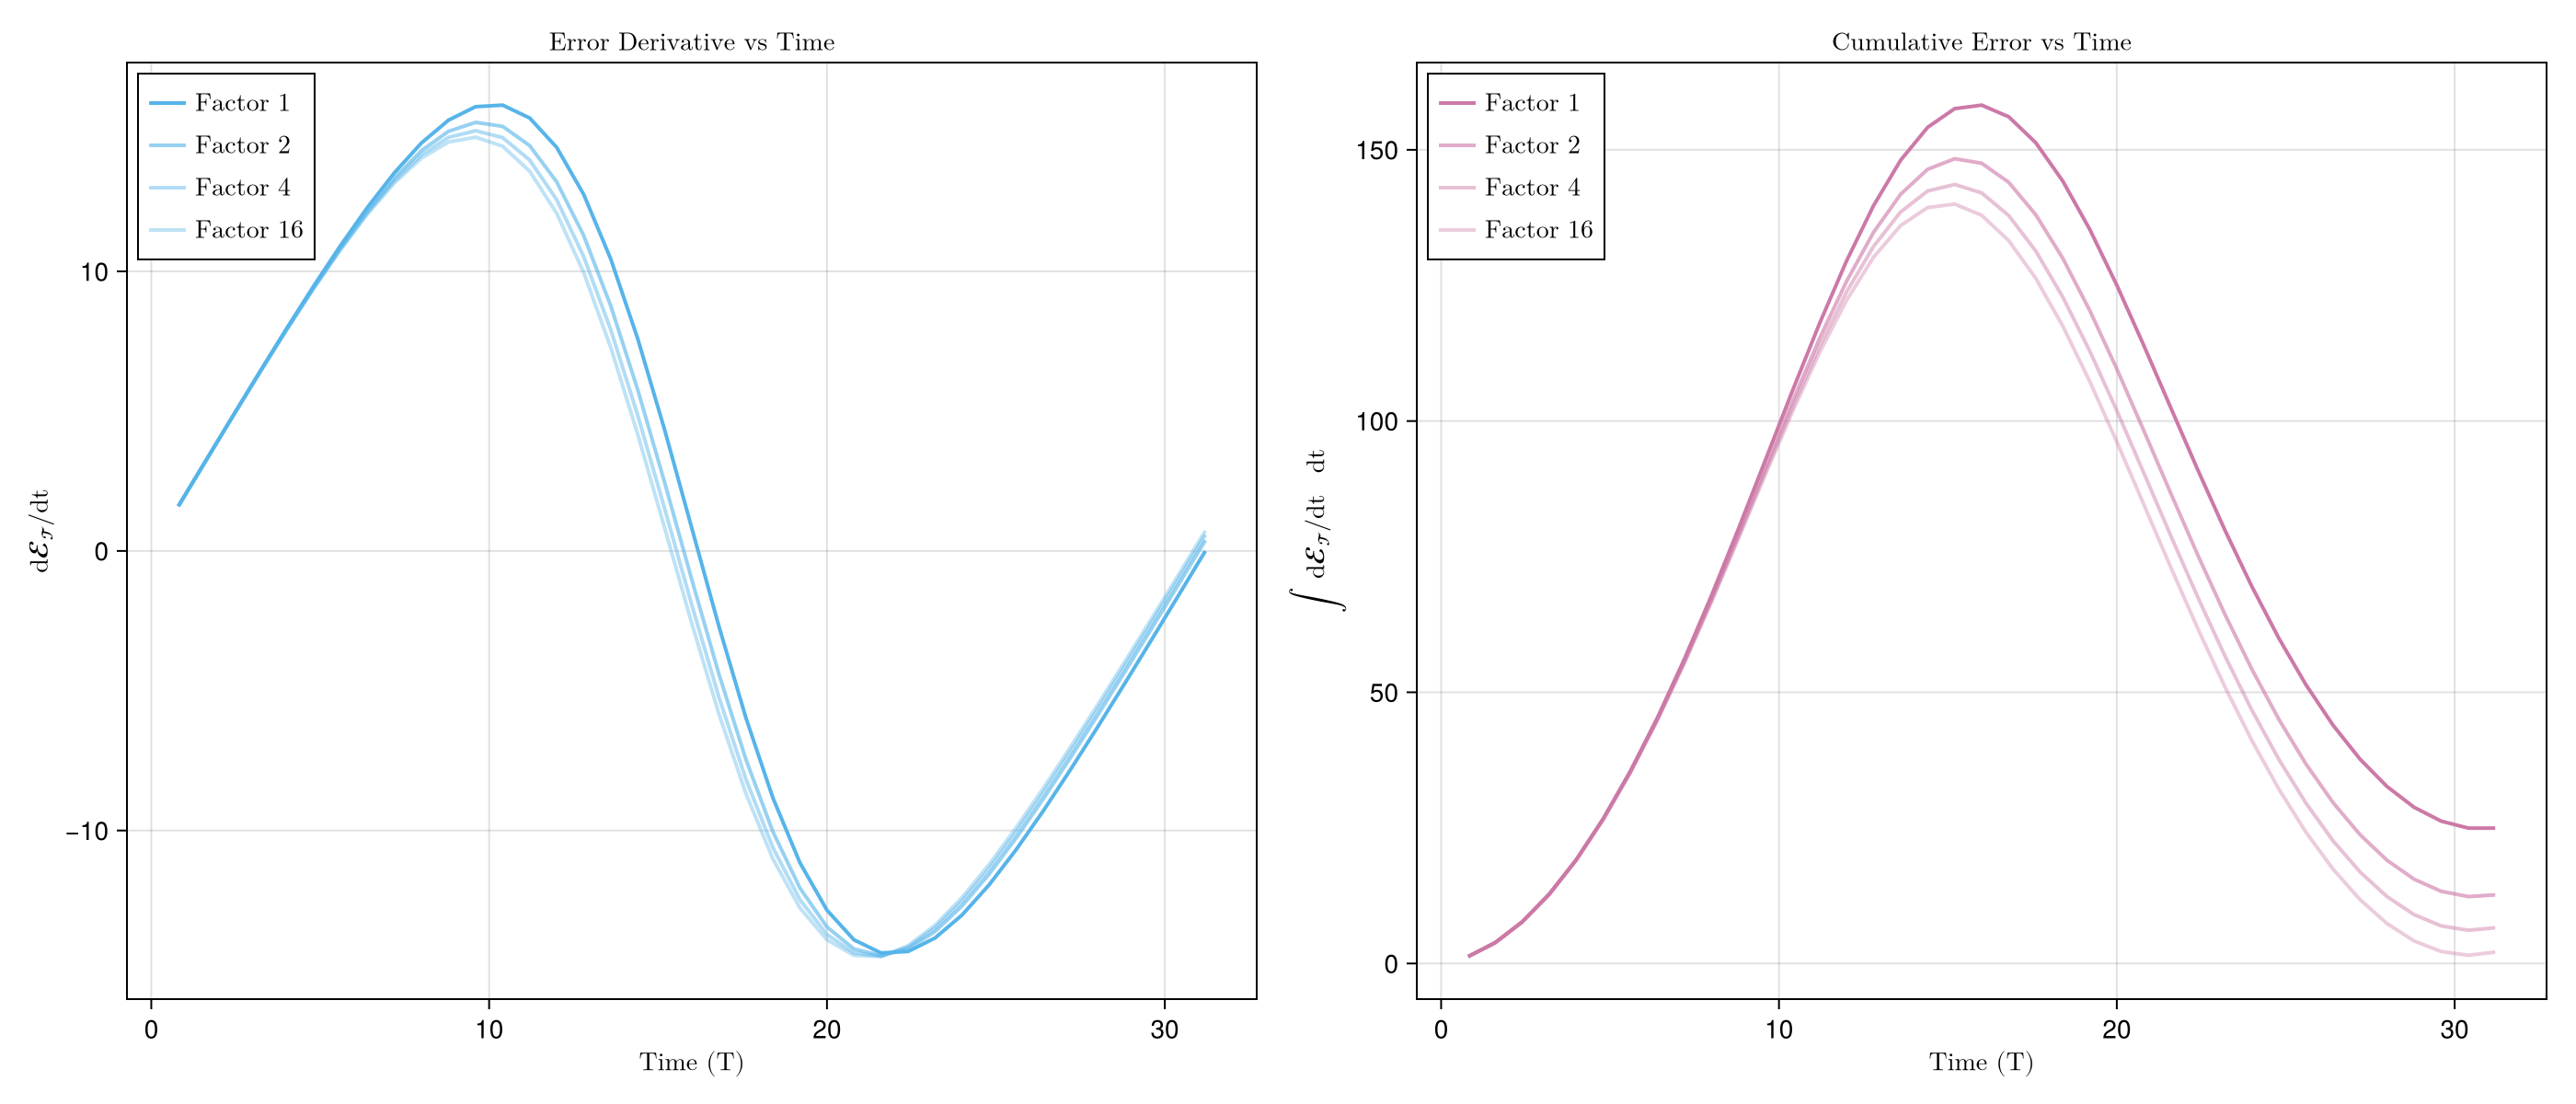

In [18]:
colors = Makie.wong_colors()

var_prob = var_probs[end, end]
tog_prob = tog_probs[end, end]
T = var_prob.trajectory.T-1
Δt = tog_prob.trajectory.Δt[1]

factors = [2^0, 2^1, 2^2, 2^4]

fig = Figure(size = (1400, 600))

# Left subplot for derivatives (blue/teal lines)
ax1 = Axis(fig[1, 1],
    title = LaTeXString("Error Derivative vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("d\\mathcal{E_T}/dt"),
)

# Right subplot for cumulative error (red/orange lines)
ax2 = Axis(fig[1, 2],
    title = LaTeXString("Cumulative Error vs Time"),
    xlabel = LaTeXString("Time (T)"),
    ylabel = LaTeXString("\\int d\\mathcal{E_T}/dt \\, dt"),
)

ts = (1:T) .* Δt

# Plot for each factor with fading color and transparency
for (i, factor) in enumerate(factors)
    # Compute error derivative at each timestep for this factor
    error_derivatives = [real(tog_deriv_up(tog_prob.trajectory, H_drive, ∂ₑHₐ[1], t; factor=factor)) for t in 1:T]
    
    # Compute cumulative error (integral of derivative)
    cumulative_error = cumsum(error_derivatives .* Δt)
    
    # Calculate alpha (transparency) - decreases with factor
    alpha = 1.0 / (i^0.7)  # Adjust the exponent to control fade rate
    
    # Create faded colors
    color_deriv = (colors[5], alpha)
    color_cumul = (colors[4], alpha)
    
    lines!(ax1, ts, error_derivatives,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_deriv
    )
    
    # Plot the cumulative error on right subplot
    lines!(ax2, ts, cumulative_error,
        label = LaTeXString("Factor $(factor)"),
        linewidth = 2,
        color = color_cumul
    )
end


# Add legends
axislegend(ax1, position = :lt)
axislegend(ax2, position = :lt)

# Display the figure
fig